In [1]:
# ---------- IMPORTAÇÃO DAS BIBLIOTECAS ---------- #

import numpy as np
import pandas as pd
import psycopg2
import pandas.io.sql as sqlio
import matplotlib.pyplot as plt
import seaborn as sns
import time

# ---------- CONEXÃO COM O BANCO DE DADOS ---------- #
# Parâmetros da Conexão
host    = 'lincpo.com.br'
port    = '2035'
dbname  = 'censo'
dbtable = 'censo_2000'
user    = 'prevdb_user'
pwd     = 'pr3v'

# Conexão com o Banco de Dados
conn = psycopg2.connect("host='{}' port={} dbname='{}'user={} password={}"
         .format(host, port, dbname, user, pwd))

if conn == -1:
    print("Não foi possível conectar a Base de Dados")
else:
    print("Conectado com sucesso")

Conectado com sucesso


# **Censo Demográfico 2010 - Análise dos Benefícios e Indíce de Gini**

* Cálculo do indíce de Gini (renda percapita e percapita domiciliar) nas base de dados dos censos de: 
     * **1991** (?)
     * **2000**
     * **2010**
* Base de Dados disponível em: ftp://ftp.ibge.gov.br/Censos/
* Resultados divulgados pelo IBGE disponível em: http://www.atlasbrasil.org.br/2013/pt/consulta/
* Unidade de amostra: **Estados**
* Análise estátisca acerca da situação dos benefícios (aposentadorias e pensões)
* Anuário estatistico da previdência (ano 2000?): http://www.previdencia.gov.br/a-previdencia/politicas-de-previdencia-social/resultados-do-rgps/

## **1. Indíce de Gini**
* Indicador que mede a desigualdade de renda
* G = 1 corresponde a total desigualdade e G = 0 corresponde a total igualdade de renda
* Pode ser cálculado como:

$G = 1 - CurvaLorenz$

ou 

$G = 1 - \sum_{i=1}^{k=n-1} (p_{k+1} - p_{k})(r_{k+1} + r_{k})$
* Onde: 
    - G - Coeficiente de Gini
    - P - Proporção acumulada da "população"
    - R - Proporção acumulada de "renda"
    
* Obs: é necessário organizar **R** de forma crescente: 

$r_{1} ≤ r_{2} ≤ r_{3} ... ≤ r_{i} ≤ ... ≤ r_{n}$

In [2]:
# ---------- CALCULO DO ÍNDICE DE GINI ---------- #

def gini( sql ):
    df = pd.read_sql_query( sql, conn )
    
    # Separa valores em renda e população
    renda = df[ 'renda' ]
    pessoas = df[ 'peso' ]
    
    # Transforma as listas em arrays
    pessoas = np.array( pessoas )
    renda = np.array( renda )

    # Organiza os dados
    aux = np.argsort( [ renda/pessoas for renda, pessoas in zip( renda, pessoas ) ], kind = "stable")
    
    renda = [j for _, j in zip( aux, renda[ aux ] )]
    pessoas = [i for _, i in zip(aux, pessoas[ aux ] )]

    # Soma acumulada de renda e pessoas 
    renda = np.cumsum( renda / sum( renda ) )
    pessoas = np.cumsum( pessoas / sum( pessoas ) )
    
    # Fŕomula do indíce de gini [ Gini = 1 - CurvaLorenz]
    g = 2 * ( 0.5 - np.trapz( renda, pessoas ) )
    
    return g, pessoas, renda

In [3]:
# ---------- PLOT DA CURVA DE LORENZ---------- #

def plotagem( pessoas, renda ):
    plt.plot( pessoas, renda, 'k' )
    plt.plot( [ 0, 1 ], 'r' )
    plt.ylim( 0, 1 ), plt.xlim( 0, 1 )
    plt.fill_between( pessoas, renda, facecolor = 'y' )

    plt.xlabel( 'Proporção de população' )
    plt.ylabel( 'Proporção de renda' )
    plt.title( 'Curva de Lorenz' )
    plt.show()

In [4]:
# --------------- ACM --------------- #

def AMC( codMunicipio, anoAMC ):
    amc = pd.read_csv('AMC.csv')

    if( amc.newcod == codMunicipio ).any() == False:
        return print( 'Codigo %s não está na base' %codMunicipio )
        
    else:
        mun = np.array( amc[ amc.newcod == codMunicipio ] )
        codOriginal = codMunicipio
        codConvertido = 0
        anoInstalacao = 0
        while( codOriginal != codConvertido ):
            if( mun[0][1] > anoAMC ):
                anoInstalacao = mun[0][1]
                codConvertido = mun[0][2]

                result = AMC( codConvertido, anoAMC )
                codOriginal = result[0]
                anoInstalacao = result[1]
                codCovertid = result[2]
            else:
                anoInstalacao = mun[0][1]
                codConvertido = codOriginal

        return codOriginal, anoInstalacao, codConvertido

### **Variáveis de Interesse da Base de Dados**

------------ 
* Variáveis de domicílios:
    - **v0001** - Código do estado
    - **v0002** - Código município 
    - **v6529** - Rendimento domiciliar
    - **v0401** - Número de moradores do domicílio
    - **v0001**  - Peso da amostra associado a quantas vezes o registro se repete

------------    
* Variáveis de pessoas:
    - **v0001** - Código do estado
    - **v0002** - Código município 
    - **v6527** - Rendimento total
    - **v0656** - Se tinha rendimento proveninete de benefício público
        - 1 - Sim
        - 0 - Não
        - 9 - Ignorado
    - **v0659** - Se tinha rendimento proveninete de benefício privado
        - 1 - Sim
        - 0 - Não
        - 9 - Ignorado
    - **v6591** - Valor total dos rendimentos nas categorias v0656 e v0659
    - **v0001** - Peso da amostra associado a quantas vezes o registro se repete
------------ 

### **Unidades Federativas e Indíce de Gini**

In [5]:
estados = [ "ac", "al", "am", "ap", "ba", "ce", "df", "es", "go", "ma", "mg", "ms", "mt",
          "pa", "pb", "pe", "pi", "pr", "rj", "rn", "ro", "rr", "rs", "sc", "se", 
          "sp1", "sp2_rm", "to" ]

results = []

for k in estados:     
    sql_RD = "SELECT \
            COALESCE( ( v6529 * v0010 ), 0 ) AS renda, ( v0010 ) AS peso \
            FROM censo_2010.domicilios_%s" %( k )

    # SQL - índice de gini renda per capita
    sql_RP = "SELECT \
            COALESCE( ( v6529 * v0010 ), 0 ) AS renda, ( v0010 * v0401 ) AS peso \
            FROM censo_2010.domicilios_%s" %( k )

    # SQL - renda per capita
    sql_Renda = "SELECT \
                ( SUM( v6529 * v0010 ) / SUM( v0401 * v0010 ) ) AS RP \
                FROM censo_2010.domicilios_%s" %( k )
    
    sql_UF = "SELECT v0001 as UF FROM censo_2010.domicilios_%s limit 1 " %( k )

    df_Renda = pd.read_sql_query( sql_Renda, conn )
    df_UF = pd.read_sql_query( sql_UF, conn )

    g_RD = gini( sql_RD )
    g_RP = gini( sql_RP )

    # Adiciona valores no array resultado
    # || ID do municipio || Gini RD || Gini RP || Renda2000 || Renda2010 ||
    results.append( [df_UF.loc[ 0, 'uf' ],
                     k,
                     g_RD[ 0 ], 
                     g_RP[ 0 ], 
                     df_Renda.loc[ 0, 'rp' ], 
                     df_Renda.loc[ 0, 'rp' ] ] )
    
# Salva em um arquivo .csv
i_gini = pd.DataFrame( results, columns = 'Cod UF Gini_RD Gini_RP RendaMedia RendaMedia2010'.split() )
i_gini.to_csv( 'results/gini2010_uf.csv', sep = '\t' )
        
print( "Processamento do cálculo do índice de Gini (ano 2010) realizado com sucesso" )

Processamento do cálculo do índice de Gini (ano 2010) realizado com sucesso


In [6]:
i_gini

,Cod,UF,Gini_RD,Gini_RP,RendaMedia,RendaMedia2010
0,12,ac,0.613287,0.640159,495.148400,495.148400
1,27,al,0.608914,0.633971,418.230973,418.230973
2,13,am,0.635544,0.666775,505.539868,505.539868
3,16,ap,0.592276,0.616360,572.726149,572.726149
4,29,ba,0.607072,0.627085,478.932429,478.932429
5,23,ce,0.599479,0.617621,443.807566,443.807566
6,53,df,0.618493,0.636369,1648.895300,1648.895300
7,32,es,0.563332,0.573406,790.790796,790.790796
8,52,go,0.560337,0.560084,780.984565,780.984565
9,21,ma,0.607021,0.628088,347.728345,347.728345


In [13]:
# ---------- CALCULO DO ÍNDICE DE GINI PARA RENDA DOMICILIAR ---------- #

estados = [ "ac", "al", "am", "ap", "ba", "ce", "df", "es", "go", "ma", "mg", "ms", "mt",
          "pa", "pb", "pe", "pi", "pr", "rj", "rn", "ro", "rr", "rs", "sc", "se", 
          "sp1", "sp2_rm", "to" ]

results = []

for k in estados:

    # Seleciona os estados e municpios
    sql = "SELECT DISTINCT( v0002 ) AS cidade FROM censo_2010.domicilios_%s" % k
    cidades = pd.read_sql_query( sql, conn )

    for i in cidades['cidade']:       
        
        # Referenciando estado e cidade (k, i)
        
        # SQL - índice de gini renda domiciliar  
        sql_RD = "SELECT \
                COALESCE( ( v6529 * v0010 ), 0 ) AS renda, ( v0010 ) AS peso \
                FROM censo_2010.domicilios_%s \
                WHERE v0002 = '%s'" %( k, i )
        
        # SQL - índice de gini renda per capita
        sql_RP = "SELECT \
                COALESCE( ( v6529 * v0010 ), 0 ) AS renda, ( v0010 * v0401 ) AS peso \
                FROM censo_2010.domicilios_%s \
                WHERE v0002 = '%s'" %( k, i )

        # SQL - renda per capita
        sql_Renda = "SELECT \
                    ( SUM( v6529 * v0010 ) / SUM( v0401 * v0010 ) ) AS RP \
                    FROM censo_2010.domicilios_%s \
                    WHERE v0002 = '%s'" %( k, i )
        
        # SQL - Unidade Federativa
        sql_UF = "SELECT v0001 as UF FROM censo_2010.domicilios_%s limit 1 " %( k )
        
        df_Renda = pd.read_sql_query( sql_Renda, conn )
        df_UF = pd.read_sql_query( sql_UF, conn )
        
        # Ajuste da renda per capita de julho de 2000 para valores em agosto de 2010
        # 99,19% de inflação no INCP
        # renda2010 = df_Renda.loc[ 0, 'rp' ] + ( df_Renda.loc[ 0, 'rp' ] * 0.9919037 )
        
        # Obs: A função "gini()" retorna um array com [índice de gini], ...
        # proporção acumulado da população] e [proporção acumulada de renda]
        
        g_RD = gini( sql_RD )
        g_RP = gini( sql_RP )
        
        # AMC do município em 2000
        cod2000 = df_UF.loc[ 0, 'uf' ] + i
        cod2000 = int( cod2000 )
        amc = AMC( cod2000, 2000 ) 
        
        # Adiciona valores no array resultado
        # || ID do municipio || Gini RD || Gini RP || Renda2000 || Renda2010 ||
        results.append( [ df_UF.loc[ 0, 'uf' ] + i,
                         amc[ 0 ],
                         g_RD[ 0 ], 
                         g_RP[ 0 ], 
                         df_Renda.loc[ 0, 'rp' ], 
                         df_Renda.loc[ 0, 'rp' ] ] )

        
# Salva em um arquivo .csv
i_gini = pd.DataFrame( results, columns = 'Cod2010 Cod2000 Gini_RD Gini_RP RendaMedia RendaMedia2010'.split() )

af = { 'Cod2010': lambda x: x.tolist(), 
      'Cod2000':'first', 
      'Gini_RD':'mean', 
      'Gini_RP':'mean', 
      'RendaMedia':'mean', 
      'RendaMedia2010':'mean' }

i_gini = i_gini.groupby( 'Cod2000' ).aggregate( af )
i_gini.drop( 'Cod2000', axis = 1, inplace = True )
i_gini.to_csv( 'results/gini2010_cidades.csv', sep = '\t' )
        
print( "Processamento do cálculo do índice de Gini (ano 2010) realizado com sucesso" )

Processamento do cálculo do índice de Gini (ano 2010) realizado com sucesso


In [14]:
i_gini

,Cod2010,Gini_RD,Gini_RP,RendaMedia,RendaMedia2010
Cod2000,,,,,
1100015,[1100015],0.574272,0.588978,467.130575,467.130575
1100023,[1100023],0.549530,0.551268,668.938453,668.938453
1100031,[1100031],0.492941,0.516153,446.537339,446.537339
1100049,[1100049],0.582037,0.589179,717.611456,717.611456
1100056,[1100056],0.508914,0.515915,550.770557,550.770557
1100064,[1100064],0.506262,0.516763,506.306290,506.306290
1100072,[1100072],0.479114,0.492911,396.060467,396.060467
1100080,[1100080],0.485106,0.527719,349.842953,349.842953
1100098,[1100098],0.528640,0.540855,570.507740,570.507740


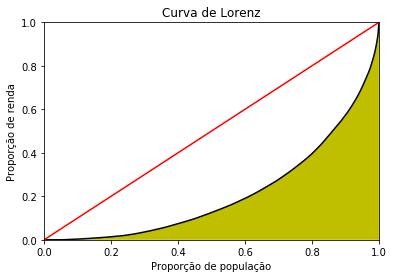

In [15]:
# Ilustração de curva de Lorenz

plotagem(g_RP[ 1 ], g_RP[ 2 ])

## **2. Participação dos benefícios de aposentadorias e pensões**

### **Rendimento de beneficios por estados**
* Renda e percentual para o total dos estados
* Renda e percentual para **aposentadorias** e **pensões** para cada estado
* Renda e percentual para **aposentadorias** e **pensões** até 1 salário mínimo
* Renda e percentual para **aposentadorias** e **pensões** acima de 1 salário mínimo
* Foi utilizado o software [Pentaho Data Integration](https://sourceforge.net/projects/pentaho/) para a realização das consultas na base de dados

In [16]:
# ---------- RESULTADOS DAS PARTICIPAÇÕES DE BENEFICIOS NO BRASIL - ESTADOS ---------- #

estados = [ "ac", "al", "am", "ap", "ba", "ce", "df", "es", "go", "ma", "mg", "ms", "mt",
          "pa", "pb", "pe", "pi", "pr", "rj", "rn", "ro", "rr", "rs", "sc", "se", 
          "sp1", "sp2_rm",  "to" ]

results = []

for k in estados: 
    # Rendimento total do estado
    sql_RT = "SELECT SUM( v6527 * v0010 ) AS RT \
            FROM censo_2010.pessoas_%s" %k

    # Rendimento total dos beneficios do estado
    sql_RB = "SELECT SUM( v6591 * v0010 ) AS RB \
            FROM censo_2010.pessoas_%s WHERE v0656 = 1" %k

    # Rendimento total dos beneficios acima de 1 salário minímo
    sql_RB_nSAL = "SELECT SUM( v6591 * v0010 ) AS RB_nSAL \
            FROM censo_2010.pessoas_%s WHERE v6591 > 510 AND v0656 = 1" %k

    # Rendimento total dos beneficios igual ou menor que 1 salário minímo
    sql_RB_1SAL = "SELECT SUM( v6591 * v0010 ) AS RB_1SAL \
            FROM censo_2010.pessoas_%s WHERE v6591 <= 510 AND v0656 = 1" %k

    df_RT = pd.read_sql_query( sql_RT, conn )
    df_RB = pd.read_sql_query( sql_RB, conn )
    df_RB_nSAL = pd.read_sql_query( sql_RB_nSAL, conn )
    df_RB_1SAL = pd.read_sql_query( sql_RB_1SAL, conn )

    RT = df_RT.loc[ 0, 'rt' ]
    RB = df_RB.loc[ 0, 'rb' ]
    RB_nSAL = df_RB_nSAL.loc[ 0, 'rb_nsal' ]
    RB_1SAL = df_RB_1SAL.loc[ 0, 'rb_1sal' ]

    results.append( [ k,
                      RT,
                      RB,
                      RB / RT,
                      RB_nSAL,
                      RB_nSAL / RT,
                      RB_1SAL,
                      RB_1SAL / RT] )

#results.append( [ "br", np.sum( results, axis=0 ) ] )

beneficios_2010_uf = pd.DataFrame( results, columns = "UF Renda(Total)\
                                                    Renda(Beneficios) Total(%)\
                                                    Beneficio(>Sal) Beneficio(>Sal)(%)\
                                                    Beneficio(<=Sal) Beneficio(<=Sal)(%)".split() )

beneficios_2010_uf.to_csv( 'results/beneficios2010_uf.csv', sep = '\t' )
        
print( "Processamento do cálculo dos benfícios (ano 2010) realizado com sucesso" )

Processamento do cálculo dos benfícios (ano 2010) realizado com sucesso


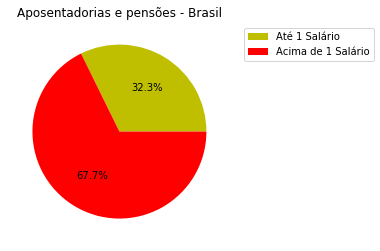

In [25]:
# Plotagem da participação de aposentadorias e pensões no total para o Brasil
import matplotlib.pyplot as plt

# Percentual de participação dos beneficios em todo o Brasil
p_total = beneficios_2010_uf['Total(%)'].sum() * 100 

# Percentual de participação dos beneficios <= 1 sal em todo o Brasil
p_um_sal = beneficios_2010_uf['Beneficio(<=Sal)(%)'].sum() * 100 

# Percentual de participação dos beneficios > 1 sal em todo o Brasil
p_mais_um_sal = beneficios_2010_uf['Beneficio(>Sal)(%)'].sum() * 100

p_total_sal = [ ( ( p_um_sal * 100 ) / p_total ), ( ( p_mais_um_sal * 100 ) / p_total ) ] 

labels = 'Até 1 Salário','Acima de 1 Salário'
plt.pie( p_total_sal, colors = [ 'y', 'r' ], autopct = '%1.1f%%' )
plt.title( 'Aposentadorias e pensões - Brasil' )
plt.legend( labels, bbox_to_anchor = ( 1.05, 1 ) )
plt.show()

In [23]:
# ---------- RESULTADOS DAS PARTICIPAÇÕES DE BENEFICIOS NO BRASIL - CIDADES ---------- #

estados = [ "ac", "al", "am", "ap", "ba", "ce", "df", "es", "go", "ma", "mg", "ms", "mt",
          "pa", "pb", "pe", "pi", "pr", "rj", "rn", "ro", "rr", "rs", "sc", "se", 
          "sp1", "sp2_rm",  "to" ]

results = []

for k in estados: 

    # Seleciona os estados e municpios
    sql = "SELECT DISTINCT( v0002 ) AS cidade FROM censo_2010.domicilios_%s" % k
    cidades = pd.read_sql_query( sql, conn )
    
    for i in cidades['cidade']:
        
        # Referenciando estado e cidade (k, i)
        
        # Rendimento total da cidade
        sql_RT = "SELECT COALESCE( SUM( v6527 * v0010 ), 0 ) AS RT \
                FROM censo_2010.pessoas_%s WHERE v0002 = '%s'" %( k, i )

        # Rendimento total dos beneficios da cidade
        sql_RB = "SELECT COALESCE( SUM( v6527 * v0010 ), 0 ) AS RB \
                FROM censo_2010.pessoas_%s WHERE v6591 <> 0 AND v0656 = 1 AND v0002 = '%s'" %( k, i )

        # Rendimento total dos beneficios acima de 1 salário minímo
        sql_RB_nSAL = "SELECT COALESCE( SUM( v6527 * v0010 ), 0 ) AS RB_NSAL \
                FROM censo_2010.pessoas_%s WHERE v6591 <> 0 AND v6591 > 510 AND v0656 = 1 AND v0002 = '%s'" %( k, i )

        # Rendimento total dos beneficios igual ou menor que 1 salário minímo
        sql_RB_1SAL = "SELECT COALESCE( SUM( v6527 * v0010 ), 0 ) AS RB_1SAL \
                FROM censo_2010.pessoas_%s WHERE v6591 <> 0 AND v6591 <= 510 AND v0656 = 1 AND v0002 = '%s'" %( k, i )

        # SQL - Unidade Federativa
        sql_UF = "SELECT v0001 as UF FROM censo_2010.domicilios_%s limit 1 " %( k )        
        
        df_UF = pd.read_sql_query( sql_UF, conn )
        df_RT = pd.read_sql_query( sql_RT, conn )
        df_RB = pd.read_sql_query( sql_RB, conn )
        df_RB_nSAL = pd.read_sql_query( sql_RB_nSAL, conn )
        df_RB_1SAL = pd.read_sql_query( sql_RB_1SAL, conn )

        RT = df_RT.loc[ 0, 'rt' ]
        RB = df_RB.loc[ 0, 'rb' ]
        RB_nSAL = df_RB_nSAL.loc[ 0, 'rb_nsal' ]
        RB_1SAL = df_RB_1SAL.loc[ 0, 'rb_1sal' ]
        
        Cod2000 = int( df_UF.loc[ 0, 'uf' ] + i )
        amc = AMC( Cod2000, 2000 )
        
        results.append( [ k,
                          df_UF.loc[ 0, 'uf' ] + i,
                          amc[ 0 ],
                          RT,
                          RB,
                          RB / RT,
                          RB_nSAL,
                          RB_nSAL / RT,
                          RB_1SAL,
                          RB_1SAL / RT] )
        
        
beneficios_2010_cid = pd.DataFrame( results, columns = "UF Cod2010 Cod2000 Renda(Total)\
                                                    Renda(Beneficios) Total(%)\
                                                    Beneficio(>Sal) Beneficio(>Sal)(%)\
                                                    Beneficio(<=Sal) Beneficio(<=Sal)(%)".split() )

af = {'UF': 'first',
      'Cod2010': lambda x: x.tolist(), 
      'Cod2000':'first', 
      'Renda(Total)':'sum', 
      'Renda(Beneficios)':'sum',
      'Total(%)': 'sum',
      'Beneficio(>Sal)': 'sum',
      'Beneficio(>Sal)(%)': 'sum',
      'Beneficio(<=Sal)': 'sum',
      'Beneficio(<=Sal)(%)':'sum' 
     }

beneficios_2010_cid = beneficios_2010_cid.groupby( 'Cod2000' ).aggregate( af )
beneficios_2010_cid[ 'Total(%)' ] = beneficios_2010_cid[ 'Renda(Beneficios)' ] / beneficios_2010_cid[ 'Renda(Total)' ]
beneficios_2010_cid[ 'Beneficio(>Sal)(%)' ] = beneficios_2010_cid[ 'Beneficio(>Sal)' ] / beneficios_2010_cid[ 'Renda(Total)' ]
beneficios_2010_cid[ 'Beneficio(<=Sal)(%)' ] = beneficios_2010_cid[ 'Beneficio(<=Sal)' ] / beneficios_2010_cid[ 'Renda(Total)' ]
beneficios_2010_cid.drop( 'Cod2000', axis = 1, inplace = True )

beneficios_2010_cid.to_csv( 'results/beneficios2010_cidades.csv', sep = '\t' )

print( "Processamento do cálculo dos benfícios para cidades (ano 2010) realizado com sucesso" )

Processamento do cálculo dos benfícios para cidades (ano 2010) realizado com sucesso


## **3. Medida de progressividade dos benefícios**

In [24]:
estados = [ "ac", "al", "am", "ap", "ba", "ce", "df", "es", "go", "ma", "mg", "ms", "mt",
          "pa", "pb", "pe", "pi", "pr", "rj", "rn", "ro", "rr", "rs", "sc", "se", 
          "sp1", "sp2_rm",  "to" ]

df_result = pd.DataFrame( data = [], columns = 'uf gini(g) parcela(ch) p_total p_1sal p_nsal'.split() )

for k in estados:

    sql = "SELECT \
                 COALESCE( v6527, 0 ) AS renda_tot, \
                 ROUND(v0010) AS peso_tot, \
                 COALESCE( CASE WHEN v0656 = 1 THEN v6591 ELSE 0 END, 0 ) AS ben_tot, \
                 COALESCE( CASE WHEN v6591 > 510 THEN 0 WHEN v6591 <= 510 AND v0656 = 1 THEN v6591 END, 0) AS ben_1sal, \
                 COALESCE( CASE WHEN v6591 <= 510 THEN 0 WHEN v6591 > 510 AND v0656 = 1 THEN v6591 END, 0) AS ben_nsal \
               FROM censo_2010.pessoas_%s WHERE v6527 <> 0 and v6527 IS NOT NULL ORDER BY v6527 ASC" %k
    
    df = pd.read_sql_query( sql, conn )     
    df = df.sort_values( 'renda_tot', kind = 'mergesorted')

    df = df.reindex( df.index.repeat( pd.to_numeric( df.peso_tot, downcast='integer') ) )
    
    #df_tot[ 'pop_cum' ] = np.arange( len( df_tot ) )
    #df_tot[ 'pop_cum' ] = df_tot.pop_cum.cumsum() / df_tot.pop_cum.sum()
    df[ 'pop_cum' ] = np.ones( len( df ) )
    df[ 'pop_cum' ] = df.pop_cum.cumsum() / df.pop_cum.size
    df[ 'renda_cum' ] = df.renda_tot.cumsum() / df.renda_tot.sum()
    df[ 'ben_cum' ] = df.ben_tot.cumsum() / df.ben_tot.sum()
    
    g = 2 * ( 0.5 - np.trapz( df.renda_cum, df.pop_cum ) )
    ch1 = 2 * ( 0.5 - np.trapz( df.ben_cum, df.pop_cum ) )
    p1 = g - ch1
    
    df[ 'ben_cum' ] = df.ben_1sal.cumsum() / df.ben_1sal.sum()
    ch2 = 2 * ( 0.5 - np.trapz( df.ben_cum, df.pop_cum ) )
    p2 = g - ch2
    
    df[ 'ben_cum' ] = df.ben_nsal.cumsum() / df.ben_nsal.sum()
    ch3 = 2 * ( 0.5 - np.trapz( df.ben_cum, df.pop_cum ) )
    p3 = g - ch3
    
    df_result = df_result.append( {'uf': k,
                                   'gini(g)': g, 
                                   'parcela(ch)': ch1, 
                                   'p_total': p1, 
                                   'p_1sal': p2, 
                                   'p_nsal': p3},
                                  ignore_index = True)
    
df_result

,uf,gini(g),parcela(ch),p_total,p_1sal,p_nsal
0,ac,0.568784,0.464021,0.104763,0.716817,-0.201916
1,al,0.579869,0.552160,0.027709,0.523136,-0.287877
2,am,0.598227,0.528311,0.069916,0.719177,-0.233367
3,ap,0.576631,0.477065,0.099566,0.672643,-0.178136
4,ba,0.579805,0.507942,0.071862,0.533989,-0.259010
5,ce,0.572996,0.506305,0.066691,0.507713,-0.286882
6,df,0.633623,0.696617,-0.062994,1.191420,-0.134939
7,es,0.556580,0.534005,0.022576,0.821025,-0.212952
8,go,0.547258,0.464543,0.082714,0.792653,-0.229255
9,ma,0.572100,0.470183,0.101918,0.406912,-0.271340


In [42]:
estados = [ "ac", "al", "am", "ap", "ba", "ce", "df", "es", "go", "ma", "mg", "ms", "mt",
          "pa", "pb", "pe", "pi", "pr", "rj", "rn", "ro", "rr", "rs", "sc", "se", 
          "sp1", "sp2_rm",  "to" ]

prog_2010_cidade = pd.DataFrame( data = [], columns = 'uf cod gini(g) parcela(ch) p_total p_1sal p_nsal'.split() )

for k in estados:

    # Seleciona os estados e municpios
    sql = "SELECT DISTINCT( v0002 ) AS cidade FROM censo_2010.domicilios_%s" % k
    cidades = pd.read_sql_query( sql, conn )
    
    for i in cidades['cidade']:
        
        sql = "SELECT \
                     COALESCE( v6527, 0 ) AS renda_tot, \
                     COALESCE( ROUND( v0010 ), 0 ) AS peso_tot, \
                     COALESCE( CASE WHEN v0656 = 1 THEN v6591 ELSE 0 END, 0 ) AS ben_tot, \
                     COALESCE( CASE WHEN v6591 > 510 THEN 0 WHEN v6591 <= 510 AND v0656 = 1 THEN v6591 END, 0) AS ben_1sal, \
                     COALESCE( CASE WHEN v6591 <= 510 THEN 0 WHEN v6591 > 510 AND v0656 = 1 THEN v6591 END, 0) AS ben_nsal \
                   FROM censo_2010.pessoas_%s WHERE v6527 <> 0 AND v0002 = %s AND v6527 IS NOT NULL ORDER BY v6527 ASC" %(k, i)        

        # SQL - Unidade Federativa
        sql_UF = "SELECT v0001 as UF FROM censo_2010.domicilios_%s limit 1 " %( k )  
        df_UF = pd.read_sql_query( sql_UF, conn )
        uf = df_UF.loc[ 0, 'uf' ]
        
        df = pd.read_sql_query( sql, conn )     
        df = df.sort_values( 'renda_tot', kind = 'mergesorted')

        df = df.reindex( df.index.repeat( pd.to_numeric( df.peso_tot, downcast='integer') ) )

        #df_tot[ 'pop_cum' ] = np.arange( len( df_tot ) )
        #df_tot[ 'pop_cum' ] = df_tot.pop_cum.cumsum() / df_tot.pop_cum.sum()
        df[ 'pop_cum' ] = np.ones( len( df ) )
        df[ 'pop_cum' ] = df.pop_cum.cumsum() / df.pop_cum.size
        df[ 'renda_cum' ] = df.renda_tot.cumsum() / df.renda_tot.sum()
        df[ 'ben_cum' ] = df.ben_tot.cumsum() / df.ben_tot.sum()

        g = 2 * ( 0.5 - np.trapz( df.renda_cum, df.pop_cum ) )
        ch1 = 2 * ( 0.5 - np.trapz( df.ben_cum, df.pop_cum ) )
        p1 = g - ch1

        df[ 'ben_cum' ] = df.ben_1sal.cumsum() / df.ben_1sal.sum()
        ch2 = 2 * ( 0.5 - np.trapz( df.ben_cum, df.pop_cum ) )
        p2 = g - ch2

        df[ 'ben_cum' ] = df.ben_nsal.cumsum() / df.ben_nsal.sum()
        ch3 = 2 * ( 0.5 - np.trapz( df.ben_cum, df.pop_cum ) )
        p3 = g - ch3

        Cod2000 = int( uf + i )
        amc = AMC( Cod2000, 2000 )        

        prog_2010_cidade = prog_2010_cidade.append( {'uf': k,
                                                    'Cod2010': str( uf ) + str( i ),
                                                    'Cod2000': str( amc[ 0 ] ),
                                                    'gini(g)': g, 
                                                    'parcela(ch)': ch1, 
                                                    'p_total': p1, 
                                                    'p_1sal': p2, 
                                                    'p_nsal': p3},
                                                      ignore_index = True)

af = {'uf':'first',
      'Cod2010': lambda x: x.tolist(), 
      'Cod2000':'first', 
      'gini(g)':'mean', 
      'parcela(ch)':'mean', 
      'p_total':'mean', 
      'p_1sal':'mean',
      'p_nsal':'mean' }

prog_2010_cidade = prog_2010_cidade.groupby( 'Cod2000' ).aggregate( af )
prog_2010_cidade.drop( 'Cod2000', axis = 1, inplace = True )
prog_2010_cidade.to_csv( 'results/progressividade_2010_cidades.csv', sep = '\t' )
prog_2010_cidade        

,uf,Cod2010,gini(g),parcela(ch),p_total,p_1sal,p_nsal
Cod2000,,,,,,,
1100015,ro,[1100015],0.536550,0.252734,0.283816,0.517293,-0.149718
1100023,ro,[1100023],0.529382,0.186075,0.343307,0.811542,-0.147242
1100031,ro,[1100031],0.473042,0.261750,0.211292,0.491943,-0.221070
1100049,ro,[1100049],0.570347,0.290172,0.280175,0.787616,-0.135999
1100056,ro,[1100056],0.509264,0.284511,0.224753,0.578193,-0.227987
1100064,ro,[1100064],0.474013,0.171772,0.302241,0.585895,-0.207833
1100072,ro,[1100072],0.467096,0.310469,0.156628,0.432401,-0.294394
1100080,ro,[1100080],0.471996,0.399344,0.072652,0.309343,-0.279286
1100098,ro,[1100098],0.511539,0.237555,0.273984,0.607698,-0.198871
